**Tutorial 8 - Markov Chain Monte Carlo**

In this tutorial we will learn how to construct a basic Metropolis-Hastings Markov Chain (MCMC) sampler and apply it to type Ia supernova data.

We will use the same supernova data we used before.  There is a nonlinear relationship between redshift and distance modulus within the standard cosmological model.  In practice it would be better to solve this problem by a non-linear $\chi^2$ fit because there are few parameters, but we will do it by MCMC as an exercises.  

 1) Make a Metropolis-Hastings stepping function.

 The function should take the following inputs: 
 x - a numpy vector giving the current position in parameter space
 
 loglike - the value of the log of the likelihood 
           evaluated at x
           
 loglike_func() - a function that returns the log of the 
            likelihood given a position in parameters space
            
 proposal_func() - a proposal function that takes a position in 
                  parameter space and returns another point

 The function should return the updated position, the updated 
 loglike at that position and a Boolean that is True if the proposed step was 
 accepted and False if it was not. 
 You can assume the proposal function is symmetric, 
i.e. $q(x | y) = q(y | x)$

Call the function MH_step()

In [507]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

In [508]:
def MH_step(p,loglike,loglike_func,proposal_func):
    #Metropolis-Hastings Monte Carlo Step
    p_new = proposal_func(p)
    loglike_new = loglike_func(p_new)
    
    warnings.filterwarnings('ignore')
    alpha = min(1, np.exp(loglike_new-loglike))
    ran=np.random.uniform(0,1, size=1)
    
    if (alpha <=1 and alpha>ran):
        return (p_new,loglike_new, True)
    
    elif (alpha <=1 and alpha<ran):
        return (p, loglike, False)
    
    elif alpha == 1:
        return (p_new, loglike_new, True)

2) Now you must make a *class* for a Gaussian proposal function called 
"gaussian_proposal_class".  The class should have a constructor that takes the standard deviation of the proposal in each dimension.  This is done by defining a \_\_init\_\_ function within it.  You should be able to call an instance of this class like a function by defining a \_\_call\_\_ function.

In [509]:
# Complete this code for a Gaussian proposal function class

class gaussian_proposal_class :
    ## This part is the constructor and 
    ## sets the internal information in the object
    # that is declared with
    # "func = gaussian_proposal_function(sigma_vector)"
    def __init__(self, sigma_step):
        self.n = len(sigma_step)
        self.sigma_step = sigma_step
        
    ##  This part defines what happens when 
    ##  you do "y = func(params)"
    ##  This should return a new point
    def __call__(self,params):
        x_t=params+self.sigma_step*np.random.normal(0, 1, size=self.n)
        return (x_t)
#
# Once this class is defined:
#
# example of creating a instance of this class
#gpf = gaussian_proposal_class(sigma)
#
# using it after it has been created
#result = gpf(params)

sigma=[1, 0.1]
tes=gaussian_proposal_class(sigma)
result=tes([20,0.2])
print(result)

[19.78704849  0.4668257 ]


In [510]:
# 3) Make a Gaussian likelihood class that stores the data and errors and 
# returns the log likelihood as a default function.

class LogGaussianLikelihood :
    def __init__(self,y_data,x_data,y_model,sigmas):
#    
#         Store the data, model and errors in the object.
#         The function y_model(params,x_data) will return the 
#         predicted value for y to be compared to y_data for 
#         any input vectors params and x_data.  This does not 
#         need to be specified here.

        self.y_data=y_data
        self.x_data=x_data
        self.y_model=y_model
        self.sigmas=sigmas
    
    def __call__(self,params):
        if (params[1]<0 or params[1]>1):
            return -1.0e100
        else:
    #         params=[]?
    #         This is the prior range on Omega matter
    #        if(params[1] < 0 or params[1] > 1) return -1.0e100
    #        
    #        Using the stored data and model and the input parameters 
    #        to calculate the log of the Gaussian likelihood and return 
    #        its value.
            dist=self.y_model(params, self.x_data)
            #likeli=(1/(np.sqrt(2*np.pi)*self.sigmas[0]))*(np.exp(-(self.y_data[0]-dist[0])**2/(2*self.sigmas[0]**2)))
            #for i in range(1,len(self.y_data)):
            #    d_likeli=(1/(np.sqrt(2*np.pi)*self.sigmas[i]))*(np.exp(-(self.y_data[i]-dist[i])**2/(2*self.sigmas[i]**2)))
            #    likeli=likeli*d_likeli
            #loglike=np.log(likeli)
            loglike = -0.5*np.sum(((self.y_data-dist)/self.sigmas)**2)
        return(loglike)

4) Write a function that returns the distance modulus with 
signature def mu_model(p,z). 

Where parameters p are:

p[0] is the absolute magnitude normalization 

p[1] is omega_matter.

z is the redshift.

Use the library function 
astropy.cosmology.FlatLambdaCDM.luminosity_distance(z).value 
to calculate the luminosity distance.  This is a nonlinear function of the omega_matter.


In [511]:
#from astropy.cosmology import FRW
import astropy.cosmology as cosmo

def mu_model(p,z):
    cos = cosmo.FlatLambdaCDM(70,p[1])
    D = 5*np.log10(cos.luminosity_distance(z).value) + p[0]
    return D

5) Read in the supernova data from SCPUnion2.1_mu_vs_z.txt and plot it.

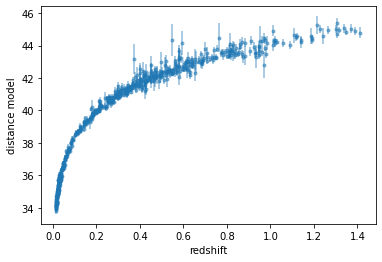

In [512]:
data=pd.read_csv('./SCPUnion2_1_mu_vs_z.txt', comment='#', delimiter="\t")
plt.errorbar(data.redshift, data.dist_mod, yerr=data.dist_mod_error, fmt='o', markersize=3, alpha=0.5)
plt.xlabel('redshift')
plt.ylabel('distance model')
plt.show()

 6) Make an instance of LogGaussianLikelihood with the data.  Call it loglike_func

Make an instance of gaussian_proposal_function

Set up the initial point p[] and its log likelihood 
 using  loglike_func(p)

Make an MCMC loop 1000 steps or more long and make a scatter plot of  the chain.  Record the acceptance fraction.


-43735.30088644715


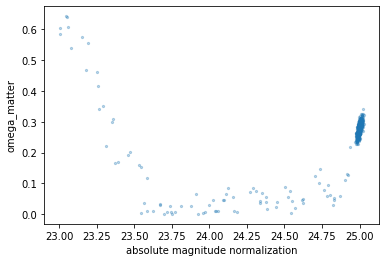

acceptance rate: 15.766666666666667


In [513]:
loglike_f = LogGaussianLikelihood (data.dist_mod, data.redshift, mu_model, data.dist_mod_error)
prop_f = gaussian_proposal_class (np.array([0.03,0.05]))
ini = np.array([23,0.6])

ini_loglike= loglike_f(ini)
print (ini_loglike)


N=3000
pos=np.zeros(shape=(N,2))
log=np.zeros(shape=N)
condition=np.zeros(shape=N)

pos[0]=ini
log[0]=ini_loglike
for i in range(1,N):
    pos[i], log[i], condition[i] = MH_step(pos[i-1],log[i-1],loglike_f, prop_f)

pos_accept=pos[np.where(condition==True)]
plt.scatter(pos_accept[:,0], pos_accept[:,1], s=5, alpha=0.3)
plt.xlabel('absolute magnitude normalization')
plt.ylabel('omega_matter')
plt.show()

print ('acceptance rate:', (len(pos_accept)/len(pos))*100)

7) Make historgrams of the two parameters.

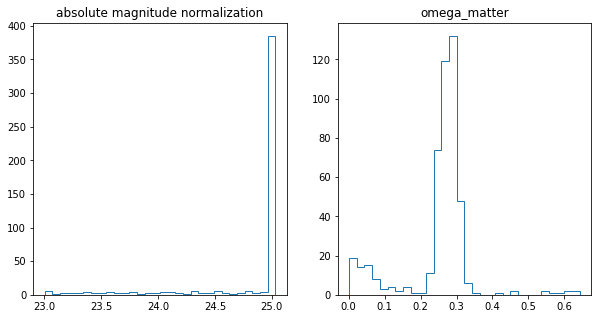

In [514]:
plt.figure(figsize=(10,5))

ax1=plt.subplot(121)
ax1.hist(pos_accept[:,0],bins=30, histtype='step', rwidth=1.5)
plt.title('absolute magnitude normalization')

ax2=plt.subplot(122)
ax2.hist(pos_accept[:,1],bins=30, histtype='step', rwidth=1.5)
plt.title('omega_matter')
plt.show()

8) Use plt.hist2d() to make a 2 dimensional histogram of the chain with labels.

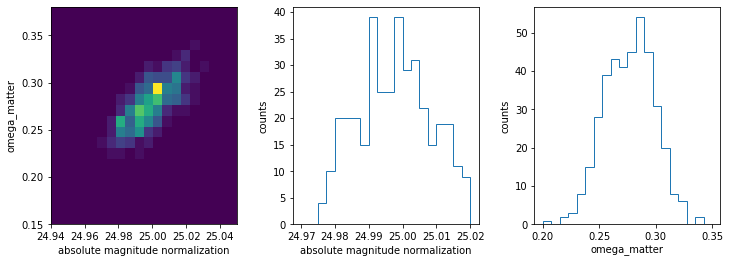

In [515]:
plt.figure(figsize=(12,4))

ax1=plt.subplot(131)
plt.hist2d(pos_accept[:,0], pos_accept[:,1], bins=20, range=[[24.94, 25.05],[0.15,0.38]])
plt.xlabel('absolute magnitude normalization')
plt.ylabel('omega_matter')

ax2=plt.subplot(132)
plt.hist(pos_accept[:,0], bins= 20, histtype='step', rwidth=1.5, range=[24.97, 25.02])
plt.xlabel('absolute magnitude normalization')
plt.ylabel('counts')

ax3=plt.subplot(133)
plt.hist(pos_accept[:,1], bins= 20, histtype='step', rwidth=1.5, range=[0.2, 0.35])
plt.xlabel('omega_matter')
plt.ylabel('counts')

plt.subplots_adjust(wspace=0.3)
plt.show()

 9) I have written a function with just a few lines missing that returns the cross-correlation function between two vectors with lag m.
 
 Use this function to estimate the correlation length 
 of your chain. Plot the auto-correlation function for 
 lags of zero to a few hundred.
 
 What is the correlation length of your chain?

In [516]:
def corrfunction(x,y):
    '''
    This function calculates the correlation coefficient 
    as a function of lag between 
    '''
    xc = x - np.mean(x)
    yc = y - np.mean(y)
    
    N = len(x)
    out = np.empty(N-2)
    stdx = np.std(xc)
    stdy = np.std(yc)

    for i in range(N-2) :
        xt = xc[0:N-i]
        yt = yc[i:N]
        if(stdx == 0 or stdy == 0):  ## this can happen for last elements
            out[i] = 0
        else :
            out[i] = np.mean(xt*yt)

    out /= (stdx*stdy)
    return out

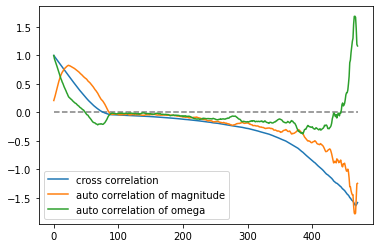

In [517]:
output_01=corrfunction(pos_accept[:,0], pos_accept[:,1])
output_00=corrfunction(pos_accept[:,0], pos_accept[:,0])
output_11=corrfunction(pos_accept[:,1], pos_accept[:,1])

lag=np.arange(0, len(pos_accept)-2)
plt.plot(lag, output_00, label='cross correlation')
plt.plot(lag, output_01, label='auto correlation of magnitude')
plt.plot(lag, output_11, label='auto correlation of omega')

plt.hlines(y=0.0, xmin=0, xmax=len(pos_accept)-2, linestyles='--', colors='gray')

plt.legend()
plt.show()

10) Calculate the mean, variance and normalized covariance of the parameters.  For a flat universe, $\Omega_m + \Omega_\Lambda = 1$ where $\Omega_\Lambda$ is the density of the cosmological constant.  What are the mean value and "1 sigma" error bars on  $\Omega_\Lambda$.

In [518]:
cov=np.cov(pos_accept[:,0], pos_accept[:,1])

def rho(mat=np.mat([])):
    dia_sqrt=np.sqrt(np.diagonal(mat))
    rho=(mat/np.outer(dia_sqrt, dia_sqrt))
    return (rho)

cov_norm=rho(cov)

print('covariance matrix:\n', cov)
print('normalized covariance matrix: \n', cov_norm)
print('-----')
print('variance of omega_matter:', cov[1][1])
print('variance of absolute magnitude', cov[0][0])
print('-----')
print('mean with 1sigma error  of omega_matter:', np.mean(pos_accept[:,1]), '+-', np.sqrt(cov[1][1]))
print('mean with 1sigma error  of absolute magnitude:', np.mean(pos_accept[:,0]),'+-', np.sqrt(cov[0][0]))

covariance matrix:
 [[0.20860273 0.00920873]
 [0.00920873 0.00921694]]
normalized covariance matrix: 
 [[1.         0.21001309]
 [0.21001309 1.        ]]
-----
variance of omega_matter: 0.009216941048660639
variance of absolute magnitude 0.20860272840964308
-----
mean with 1sigma error  of omega_matter: 0.25053083211381083 +- 0.09600490116999569
mean with 1sigma error  of absolute magnitude: 24.81534806941812 +- 0.4567304767690055
